In [1]:
import rctorch
import torch

In [2]:
site_a

NameError: name 'site_a' is not defined

0.5 7.3890560989306495
0.5 2.718281828459045
0.5 0.38674102345450123
0.5 0.36787944117144233
0.5 0.1353352832366127


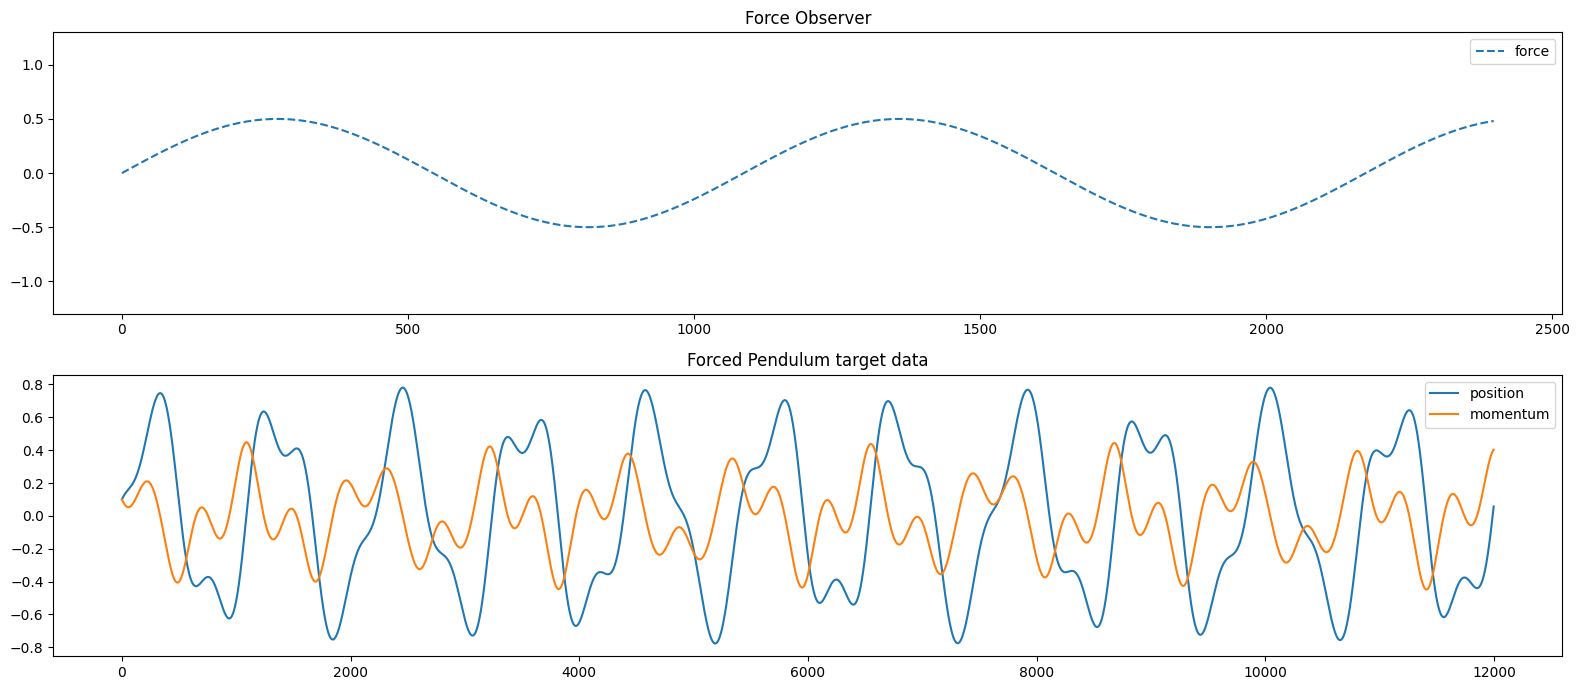

In [5]:
fp_data = rctorch.data.load("forced_pendulum", train_proportion = 0.2)

force_train, force_test = fp_data["force"]
target_train, target_test = fp_data["target"]

#Alternatively you can use sklearn's train_test_split.

In [8]:
force_train

tensor([0.0000, 0.0029, 0.0058,  ..., 0.4792, 0.4800, 0.4808])

In [16]:
#declare the hyper-parameters
hps = {'connectivity': 0.4,
           'spectral_radius': 1.13,
           'n_nodes': 202,
           'regularization': 1.69,
           'leaking_rate': 0.0098085,
           'bias': 0.49}

/Users/z6f/anaconda3/envs/rc/lib/python3.9/site-packages/rctorch/rc.py:3160: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3641.)
  input_t =  X[t, :].T


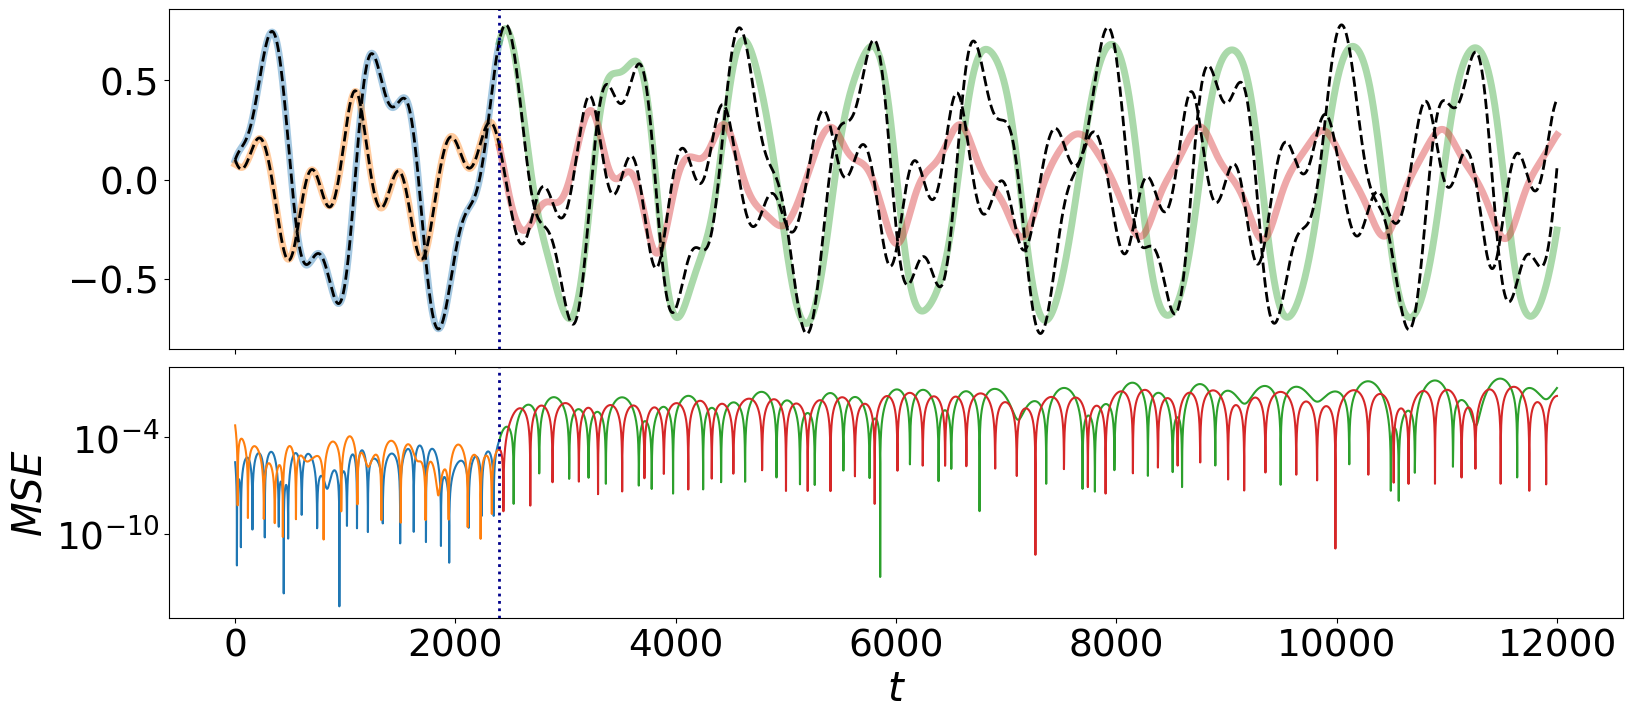

In [7]:
my_rc = RcNetwork(**hps, random_state = 210, feedback = True)

#fitting the data:
my_rc.fit(y = target_train)

#making our prediction
score, prediction = my_rc.test(y = target_test)
my_rc.combined_plot()


In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from datetime import datetime

## see how it does on pm2.5
pm25_data = pd.read_csv('../data/daily_pm/pm_2002.csv')
time_map = lambda date: datetime.strptime(date,'%Y-%m-%d').toordinal()
site_a = pm25_data[pm25_data['Site']==10030010]
site_a['Time'] = site_a['Date'].apply(time_map)




/var/folders/tm/mw0_yxrx1419zt6ys2b7vd6x_klh1b/T/ipykernel_26263/790425688.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  site_a['Time'] = site_a['Date'].apply(time_map)


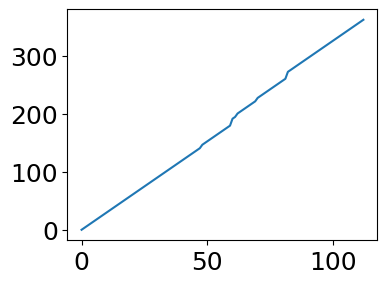

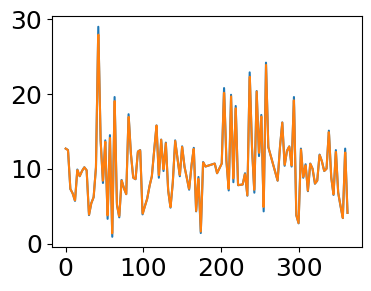

In [40]:
from scipy.interpolate import interp1d

times = site_a['Time'].to_numpy()
pm = site_a['Conc'].to_numpy()


# map to a regular grid
times = times-times[0]
regular_times = np.linspace(times[0], times[-1],8*len(times))
regular_pm = interp1d(times, pm, kind='linear')(regular_times)


f,ax = plt.subplots(figsize=(4,3))
ax.plot(times)

f,ax = plt.subplots(figsize=(4,3))
ax.plot(times,pm)
ax.plot(regular_times, regular_pm)

In [ ]:
#declare the hyper-parameters
hps = {'connectivity': 0.4,
           'spectral_radius': 1.13,
           'n_nodes': 202,
           'regularization': 1.69,
           'leaking_rate': 0.0098085,
           'bias': 0.49}

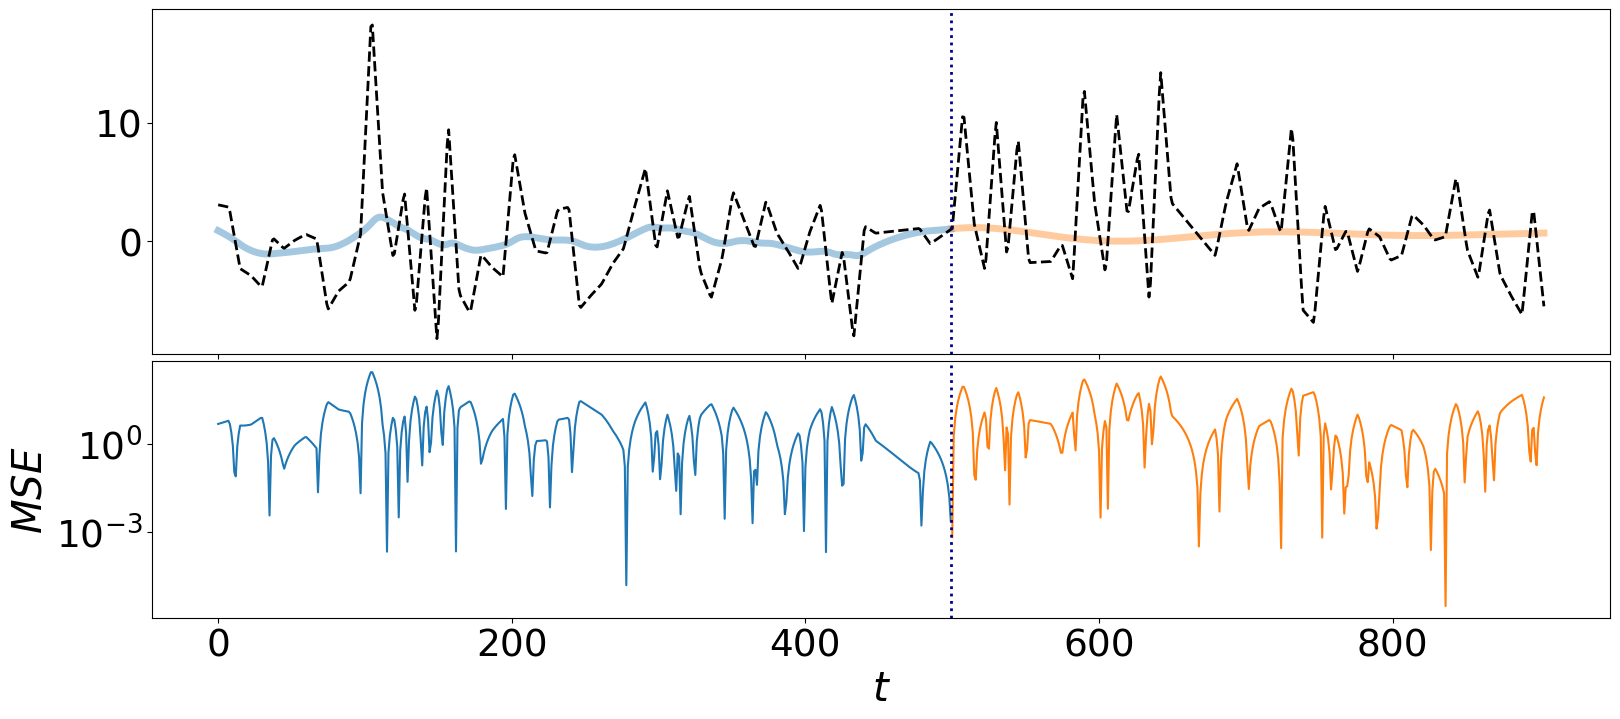

In [19]:
target_train = torch.Tensor(regular_pm[:500]-np.mean(regular_pm[:500]))
target_test = torch.Tensor(regular_pm[500:]-np.mean(regular_pm[:500])) 

my_rc = rctorch.RcNetwork(**hps, random_state = 210, feedback = True)

#fitting the data:
my_rc.fit(y = target_train)

#making our prediction
score, prediction = my_rc.test(y = target_test)
my_rc.combined_plot()

In [21]:
#any hyper parameter can have 'log_' in front of it's name. RcTorch will interpret this properly. 
bounds_dict = {"log_connectivity" : (-2.5, -0.1), 
               "spectral_radius" : (0.1, 3),
               "n_nodes" : (300,302),
               "log_regularization" : (-3, 1),
               "leaking_rate" : (0, 0.2),
               "bias": (-1,1),
               }
rc_specs = {"feedback" : True,
             "reservoir_weight_dist" : "uniform",
             "output_activation" : "tanh",
             "random_seed" : 209}

rc_bo = rctorch.RcBayesOpt(bounds = bounds_dict, 
                    scoring_method = "nmse",
                    n_jobs = 1,
                    cv_samples = 3,
                    initial_samples= 25,
                    **rc_specs)

opt_hps = rc_bo.optimize( n_trust_regions = 4, 
                                  max_evals = 500,
     #                             X = force_train, 
                                  scoring_method = "nmse",
                                  y = target_train)

cpu


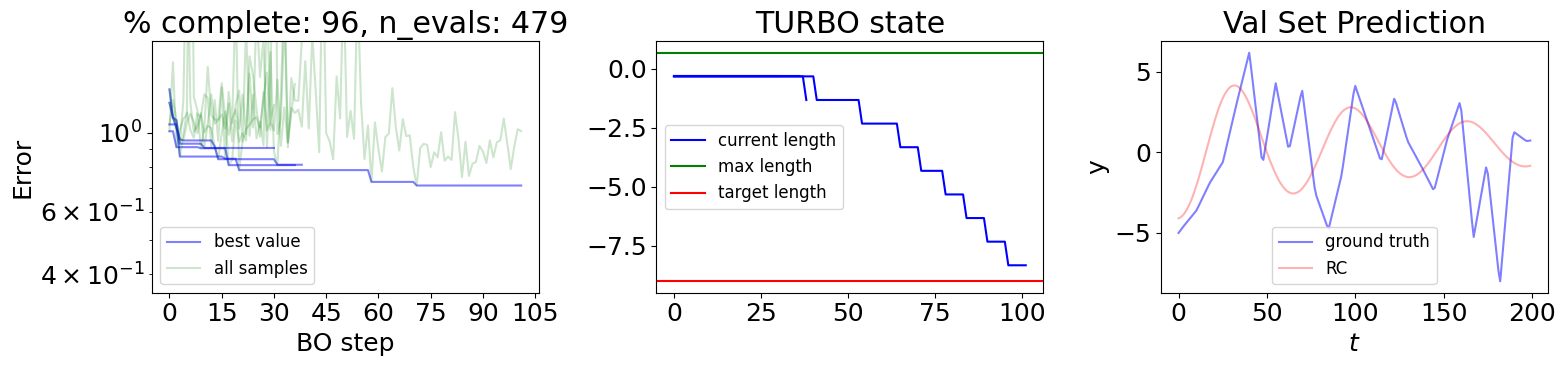

In [23]:
opt_hps

{'spectral_radius': 1.7894928455352783,
 'n_nodes': 300.9111022949219,
 'leaking_rate': 0.03635382652282715,
 'bias': -0.724237322807312,
 'connectivity': 0.003915975412302361,
 'regularization': 0.03212617820691954}

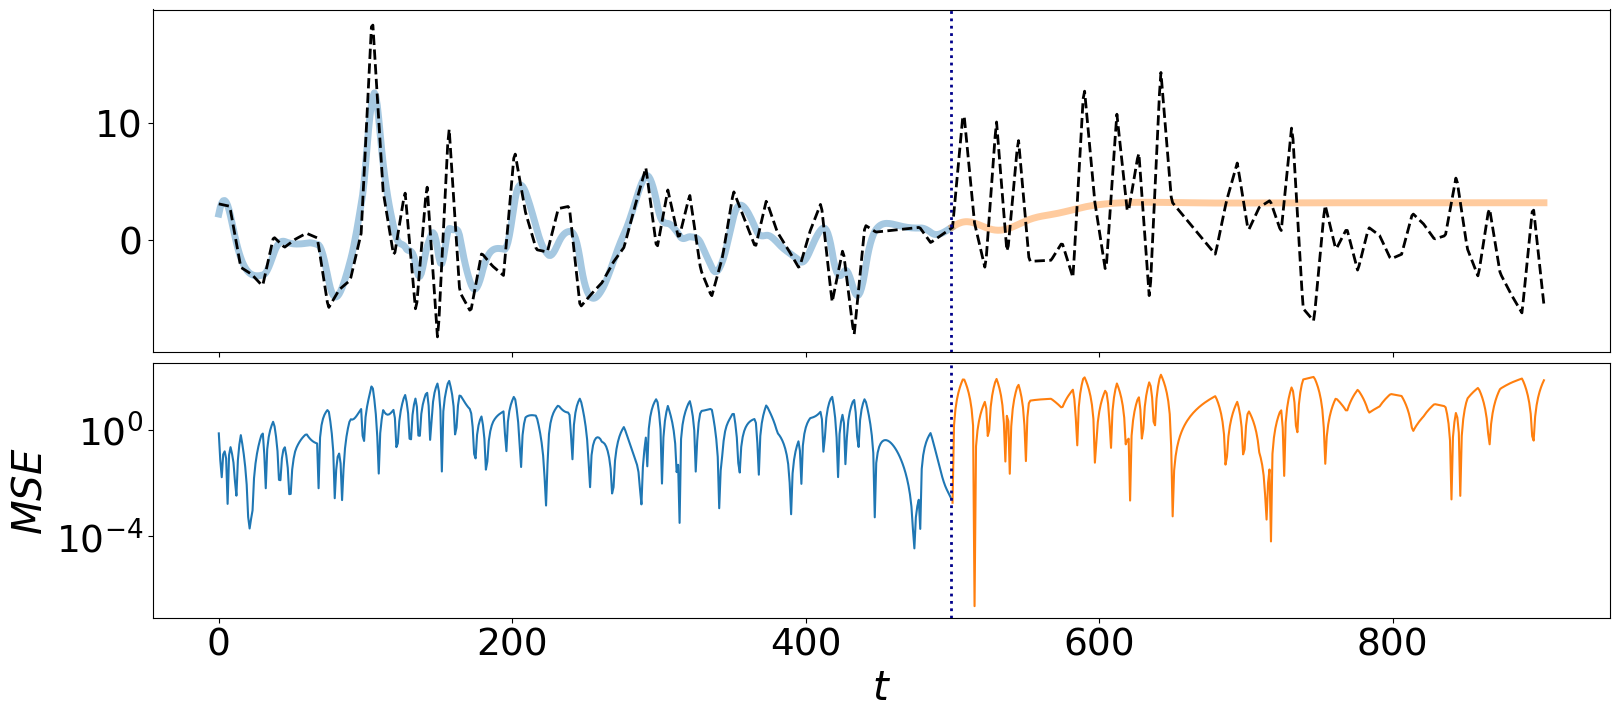

In [30]:
my_rc = rctorch.RcNetwork(**opt_hps, random_state = 210, feedback = True)

#fitting the data:
my_rc.fit(y = target_train)

#making our prediction
score, prediction = my_rc.test(y = target_test)
my_rc.combined_plot()

# nearest sites as forces

In [33]:
groups = pm25_data.groupby('Site')
site_lat = site_a.loc[0].Lat
site_lon = site_a.loc[0].Lon
distances = []; sites = []
for group in groups: 
    if group[0]!=10030010:
        sites.append(group[0])
        distances.append(np.sqrt((site_lat-group[1].iloc[0].Lat)**2+(site_lon-group[1].iloc[0].Lon)**2))

In [35]:
nearest_inds = np.argsort(distances)
nearest_sites = np.array(sites)[nearest_inds]
site_b = pm25_data[pm25_data['Site']==nearest_sites[0]]
site_b['Time'] = site_b['Date'].apply(time_map)

/var/folders/tm/mw0_yxrx1419zt6ys2b7vd6x_klh1b/T/ipykernel_26263/1840200279.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  site_b['Time'] = site_b['Date'].apply(time_map)


In [39]:
timesb = site_b['Time'].to_numpy()
pmb = site_b['Conc'].to_numpy()
times = site_a['Time'].to_numpy()


# map to a regular grid
times = times-times[0]
timesb = timesb-timesb[0]
regular_times = np.linspace(times[0], times[-1],8*len(times))
regular_pm_b = interp1d(timesb, pmb, kind='linear')(regular_times)

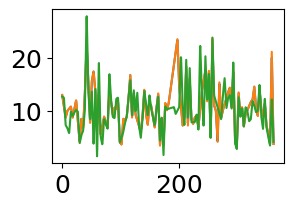

In [42]:
f,ax = plt.subplots(figsize=(3,2))
ax.plot(regular_times, regular_pm_b)
ax.plot(timesb,pmb)
ax.plot(regular_times, regular_pm)

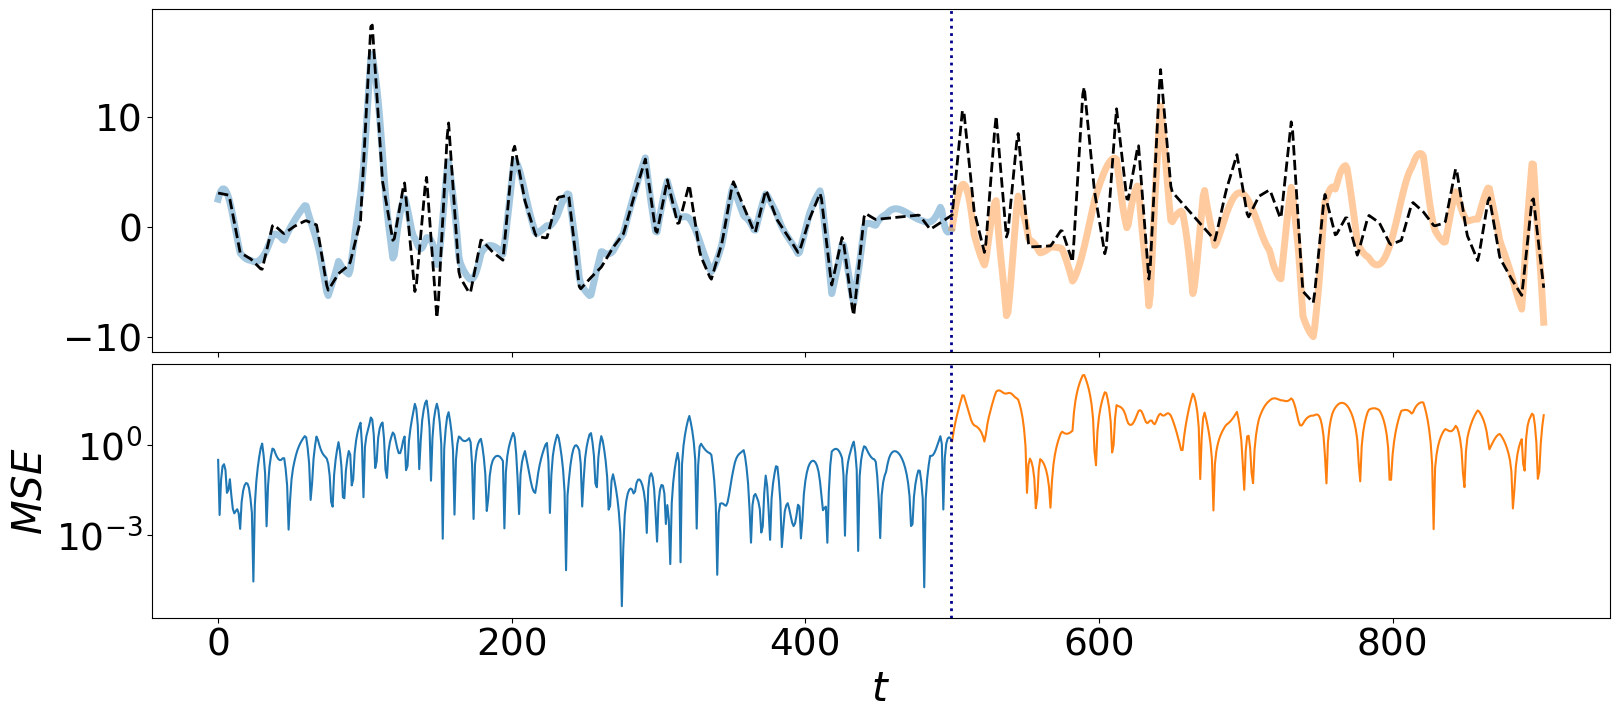

In [47]:
X_train = torch.Tensor(regular_pm_b[:500]-np.mean(regular_pm_b[:500]))
X_test = torch.Tensor(regular_pm_b[500:]-np.mean(regular_pm_b[:500]))
my_rc = rctorch.RcNetwork(**opt_hps, random_state = 210, feedback = True)

#fitting the data:
my_rc.fit(y = target_train, X=X_train)

#making our prediction
score, prediction = my_rc.test(y = target_test, X=X_test)
my_rc.combined_plot()

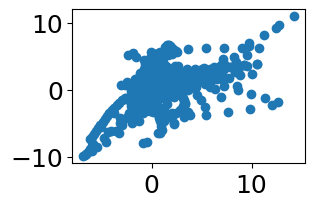

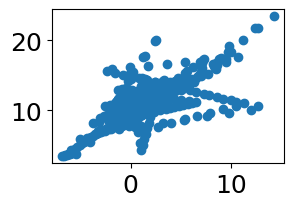

In [45]:
f,ax = plt.subplots(figsize=(3,2))
ax.scatter(target_test, prediction)
f,ax = plt.subplots(figsize=(3,2))
ax.scatter(target_test, X_test)

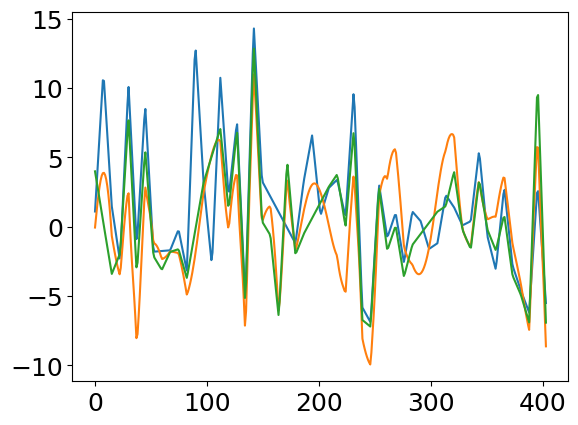

In [48]:
f,ax = plt.subplots()
ax.plot(target_test)
ax.plot(prediction)
ax.plot(X_test)

In [51]:
prediction_error = np.sum( (target_test-prediction).numpy()**2 )
neighbor_error = np.sum( (X_test-target_test).numpy()**2)
neighbor_as_prediction = np.sum( (X_test-prediction).numpy()**2)

In [53]:
prediction_error = np.sum( np.abs((target_test-prediction).numpy()) )
neighbor_error = np.sum( np.abs((X_test-target_test).numpy()))
neighbor_as_prediction = np.sum( np.abs((X_test-prediction).numpy()))

In [54]:
print(prediction_error, neighbor_error, neighbor_as_prediction)

692790.56 818.3515 639223.06


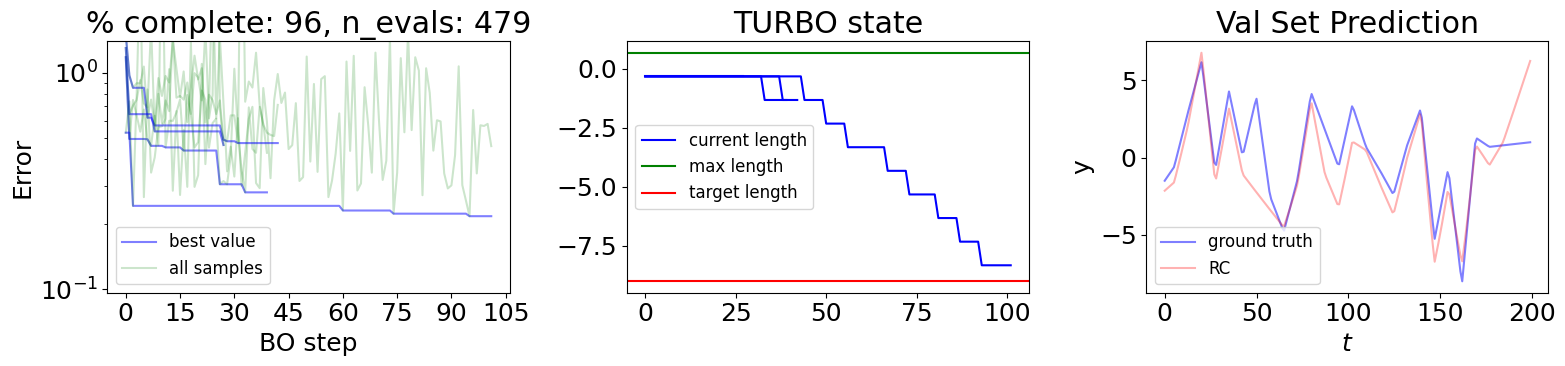

In [55]:
#any hyper parameter can have 'log_' in front of it's name. RcTorch will interpret this properly. 
bounds_dict = {"log_connectivity" : (-2.5, -0.1), 
               "spectral_radius" : (0.1, 3),
               "n_nodes" : (300,302),
               "log_regularization" : (-3, 1),
               "leaking_rate" : (0, 0.2),
               "bias": (-1,1),
               }
rc_specs = {"feedback" : True,
             "reservoir_weight_dist" : "uniform",
             "output_activation" : "tanh",
             "random_seed" : 209}

rc_bo = rctorch.RcBayesOpt(bounds = bounds_dict, 
                    scoring_method = "nmse",
                    n_jobs = 1,
                    cv_samples = 3,
                    initial_samples= 25,
                    **rc_specs)

opt_hps = rc_bo.optimize( n_trust_regions = 4, 
                                  max_evals = 500,
                                  X = X_train, 
                                  scoring_method = "nmse",
                                  y = target_train)

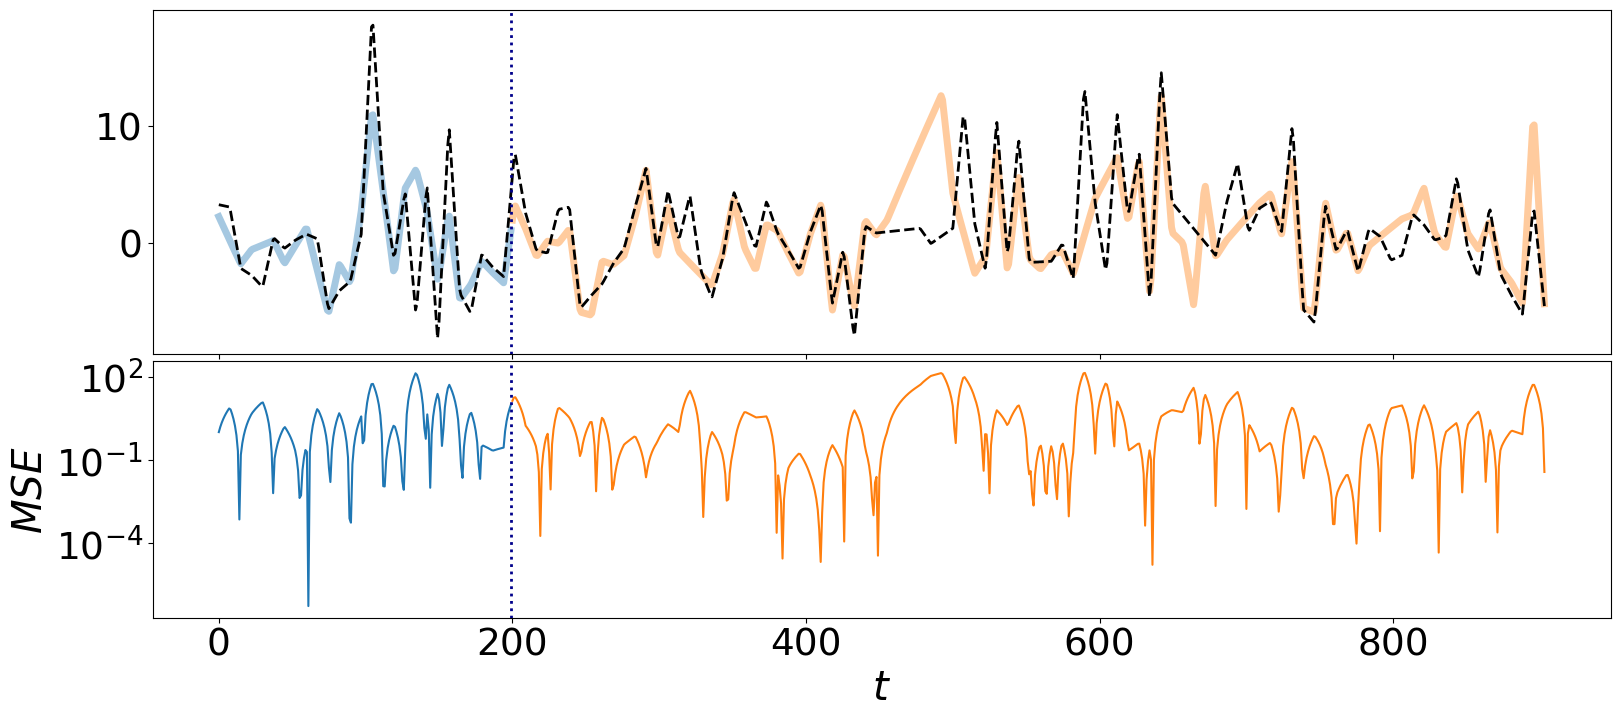

In [63]:
stop = 200
target_train = torch.Tensor(regular_pm[:stop]-np.mean(regular_pm[:stop]))
target_test = torch.Tensor(regular_pm[stop:]-np.mean(regular_pm[:stop]))
X_train = torch.Tensor(regular_pm_b[:stop]-np.mean(regular_pm_b[:stop]))
X_test = torch.Tensor(regular_pm_b[stop:]-np.mean(regular_pm_b[:stop]))

my_rc = rctorch.RcNetwork(**opt_hps, random_state = 200, feedback = True)

#fitting the data:
my_rc.fit(y = target_train, X=X_train)

#making our prediction
score, prediction = my_rc.test(y = target_test, X=X_test)
my_rc.combined_plot()

In [60]:
opt_hps

{'spectral_radius': 1.7016490697860718,
 'n_nodes': 300.3988342285156,
 'leaking_rate': 0.0024136858992278576,
 'bias': -0.9717918634414673,
 'connectivity': 0.10105426073456988,
 'regularization': 8.774112748193566}

In [64]:
prediction_error = np.sum( np.abs((target_test-prediction).numpy()) )
neighbor_error = np.sum( np.abs((X_test-target_test).numpy()))
neighbor_as_prediction = np.sum( np.abs((X_test-prediction).numpy()))
print(prediction_error, neighbor_error, neighbor_as_prediction)

1855632.5 1493.7686 1944811.6


In [65]:
prediction_error = np.sum( (target_test-prediction).numpy()**2 )
neighbor_error = np.sum( (X_test-target_test).numpy()**2)
neighbor_as_prediction = np.sum( (X_test-prediction).numpy()**2)
print(prediction_error, neighbor_error, neighbor_as_prediction)

11616394.0 6868.4844 12677276.0
